# AMC Worksheet


Use this notebook to load AMC experiments to do a deep-dive analysis.

## Notebook code

Skip this part - it is necessary only for creating the diagrams.  You may also toggle the code-view button.

In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off code view"></form>''')


## Analyze AMC Experiment


 - [Read the results log file](#Read-the-results-log-files)
 - [Plot experiment performance](#Plot-experiment-performance)
 - [Compare multiple experiments](#Compare-experiments)
 - [Sample best networks](#Sample-best-networks)
 - [PCA projection](#Two-dimesional-PCA-projection)
 - [Plot action distributions](#These-are-the-actions-the-networks-experienced)
 - [Plot the learning process projected to 2D-space](#Network-2D-embeddings)
 - [Plot actions distributions](#Plot-a-histogram-of-the-actions)

In [1]:
%matplotlib inline

from amc_worksheet_jupyter import *

### Read the results log files

The code below reads the log file of your selected experiment.  To change the path to the file you will need to open the code cell and change its content.

In [2]:
#pd.set_option('display.max_colwidth', 150)

import os

EXPERIMENTS_DIR = os.path.join("/experiments", "amc")

# expr_dir = os.path.join(EXPERIMENTS_DIR,
#                         "mobilenet_v1_training___2019.06.30-084753-ddpg-reconstruction",
#                         "2019.08.02-023635")
# fpath = os.path.join(expr_dir, "0___2019.08.02-023641")
# fpath = os.path.join(expr_dir, "1___2019.08.02-023641")
# fpath = os.path.join(expr_dir, "2___2019.08.02-023641")
# fpath = os.path.join(expr_dir, "3___2019.08.02-023641")

expr_dir = os.path.join(EXPERIMENTS_DIR,
                        "plain20-ddpg-private",
                        "2019.08.01-181040")
#fpath = os.path.join(expr_dir, "0___2019.08.01-181048")
fpath = os.path.join(expr_dir, "1___2019.08.01-181047")
# fpath = os.path.join(expr_dir, "2___2019.08.01-181047")
# fpath = os.path.join(expr_dir, "3___2019.08.01-181047")

fname = os.path.join(fpath, "amc.csv")
print(fname)
df = pd.read_csv(fname)

/experiments/amc/plain20-ddpg-private/2019.08.01-181040/1___2019.08.01-181047/amc.csv


### Plot experiment performance

In [3]:
@interact(window_size=(0,50,5), top1=True, macs=True, params=False, reward=True)
def plot_performance_proxy(window_size=10, top1=True, macs=True, params=False, reward=True):
    plot_performance("Training Data", df, 0.15, window_size, top1, macs, params, reward)

interactive(children=(IntSlider(value=10, description='window_size', max=50, step=5), Checkbox(value=True, des…

### Compare experiments

If you have multiple experiments, you can compare them here.

In [4]:
import auto_compression_jupyter as acj

df_list = acj.load_experiment_instances(expr_dir)
df_len = min([len(df) for df in df_list])

@interact(window_size=(0,50,5), top1=True, macs=True, params=False, reward=True, zoom=(0,df_len,1))
def plot_experiment_comparison(window_size=10, zoom=0):
    start = 0
    end = zoom if zoom > 0 else 0
    acj.plot_performance("Compare Experiments (Top1)", df_list, 
                          0.15, window_size, True, False, False, False, start, end, plot_type='compare')

interactive(children=(IntSlider(value=10, description='window_size', max=50, step=5), IntSlider(value=0, descr…

In [5]:
@interact(window_size=(0,50,5), top1=True, macs=True, params=False, reward=True)
def plot_experiment_comparison(window_size=10):
    plot_performance("Compare Experiments (Top1)\nError view", df_list, 
                     0.15, window_size, True, False, False, False, plot_type='error')

interactive(children=(IntSlider(value=10, description='window_size', max=50, step=5), Output()), _dom_classes=…

### Sample best networks

Let's look at the networks with the best top1 accuracy, and see if they share geometrical attributes.

We sort the discovered networks by their search-Top1 accuracy and display the density of each layer in the networks.  

Unique:  8


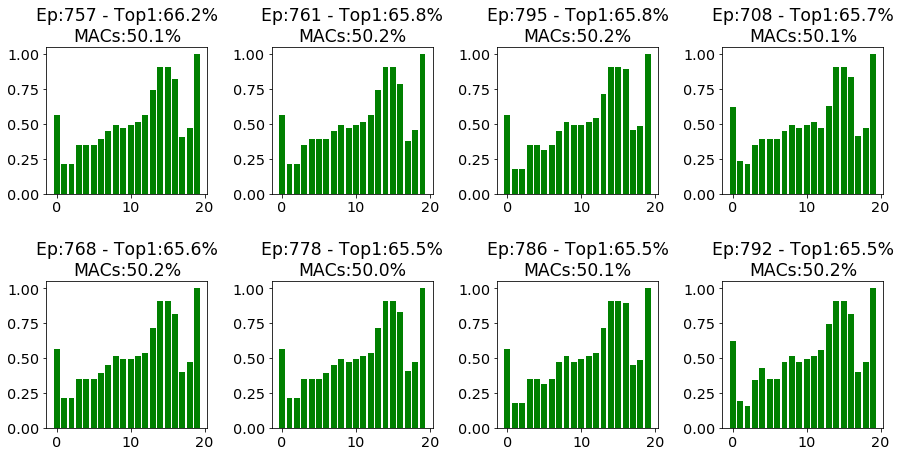

In [6]:
import hashlib
from collections import OrderedDict

# Choose network to study
df = df
top1_sorted_df = df.sort_values(by=['reward'], ascending=False)


nrows = 2; ncols = 4
f, axarr = plt.subplots(nrows, ncols, figsize=(15,7))
arch_dict = OrderedDict()
arch_shapes_dict = OrderedDict()
for i in range(0, nrows * ncols):
    record = top1_sorted_df.iloc[i]
    episode = record['episode']
    net_layer_sizes = json.loads(record["performance"])
    #print("{}".format(type(list(net_layer_sizes.values())[0])))
    net_as_nparray = np.array(list(net_layer_sizes.values()), dtype=np.float32)
    arch_shapes_dict[episode] = net_as_nparray
    net_str = ",".join(str(layer_size) for layer_size in net_layer_sizes.values())
    net_hash = hashlib.sha1(net_str.encode())
    try:        
        arch_dict[net_hash].append(episode)
    except KeyError:
        arch_dict[net_hash] = [episode]
    
    plot_layer_compute_densities(top1_sorted_df, i, ax=axarr[i//ncols, i%ncols], color='g')
    # Fine-tune figure; make subplots farther from each other.
    f.subplots_adjust(hspace=0.6, wspace=0.4)
    
print("Unique: ", len(arch_dict))

### Two-dimesional PCA projection

We can get a notion of the degree of similarities of the discovered networks, but projecting their architectures onto a lower-dimensional space, using PCA projection.
To do this we convert each network architecture to a numpy array, where each coefficient in the array is the normalized number of weight elements left in the layer's weights (i.e. this is the density of the layer weights).

Which components explain the variance best [0.63029018 0.22002047]


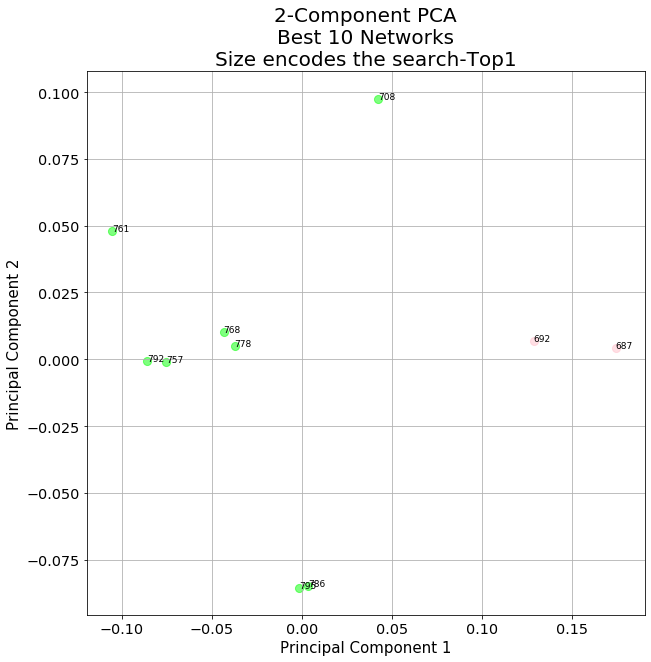

In [7]:
arch_shapes_dict = collect_info(top1_sorted_df[0:10])
pca_projection(arch_shapes_dict,
               title='2-Component PCA\nBest 10 Networks\nSize encodes the search-Top1',
               show_legend=False, show_episode_ids=True)

Let's look at the projection of the entire set of discovered networks.  Each 100 episodes are color-coded using a different color.

We can see how AMC follows a "discovery manifold" and slowly searches and discovers "better" networks in the manifold.

Which components explain the variance best [0.41691629 0.25621805]


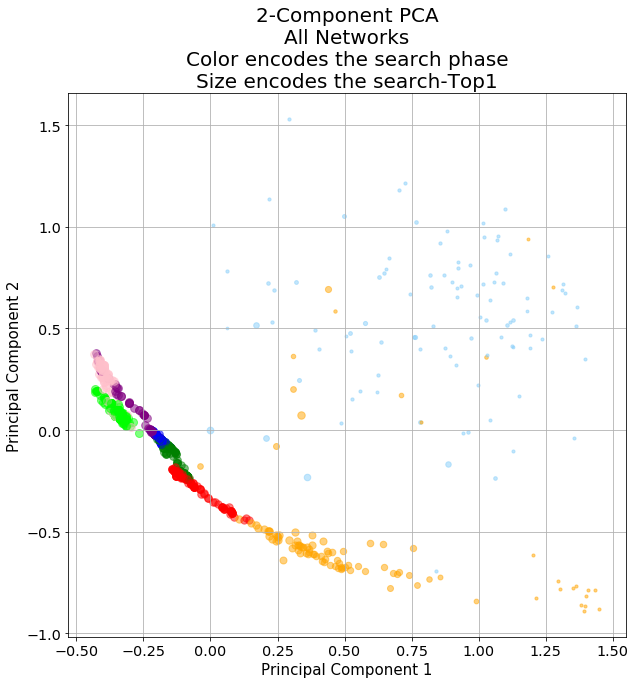

In [8]:
arch_shapes_dict = collect_info(top1_sorted_df)
pca_projection(arch_shapes_dict,
               title="2-Component PCA\nAll Networks\nColor encodes the search phase"
                     "\nSize encodes the search-Top1",
               show_legend=False, show_episode_ids=False)

### These are the actions the networks experienced

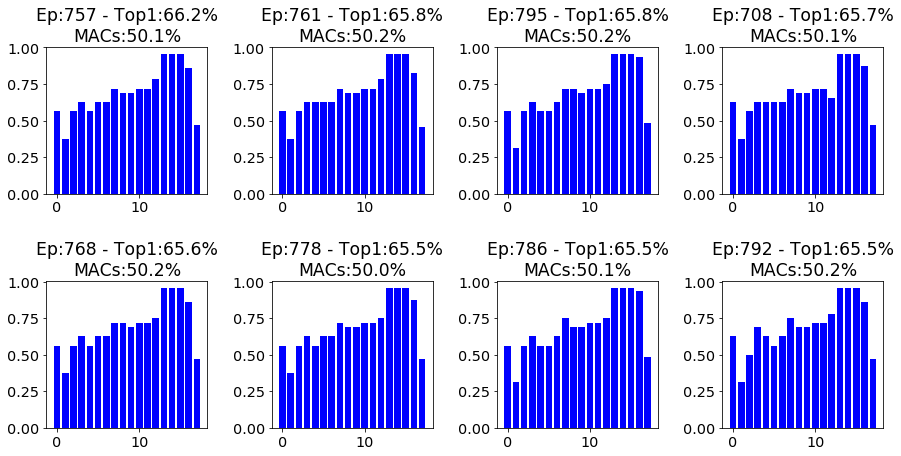

In [9]:
top1_sorted_df = df.sort_values(by=['reward'], ascending=False)
nrows = 2; ncols = 4
f, axarr = plt.subplots(nrows, ncols, figsize=(15,7))
for i in range(0, nrows * ncols):
    plot_action_history(top1_sorted_df, i, ax=axarr[i//ncols, i%ncols], color='b')
    # Fine-tune figure; make subplots farther from each other.
    f.subplots_adjust(hspace=0.6, wspace=0.4)

### Per-layer filter density distribution - top 10% networks

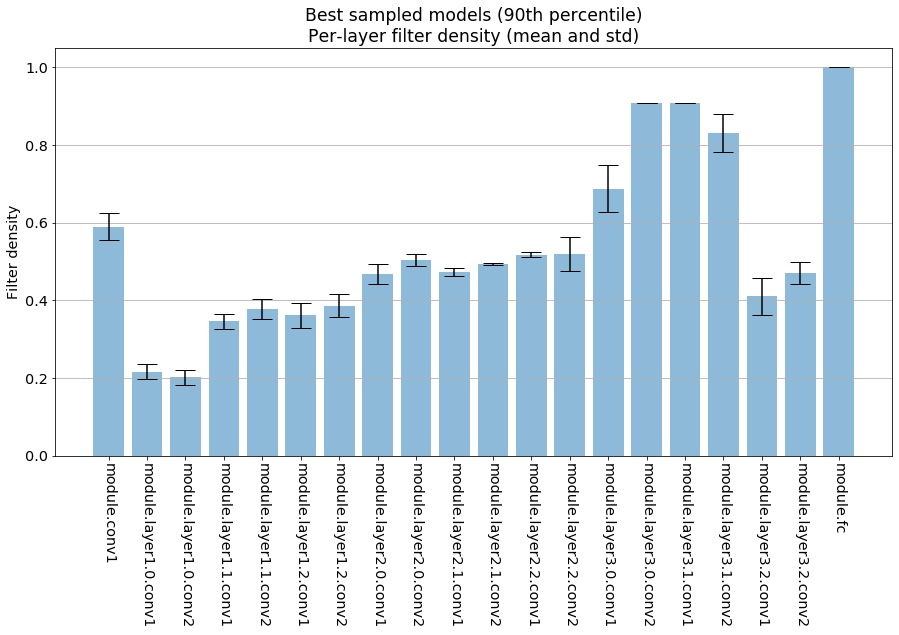

In [10]:
top10pct = top1_sorted_df[:int(len(df.index) * 0.1)]
#top10pct = df[int(len(df.index) * 0.95):]

layer_densities_list = []
for index, row in top10pct.iterrows():
    layer_densities = json.loads(row['performance'])
    layer_densities = list(layer_densities.values())

    #net_performance = json.loads(record["performance"])
    #ax.bar(range(len(net_performance)), list(net_performance.values()), color=color, align='center')

    #layer_densities = [1. - float(sparsity) for sparsity in layer_sparsities]
    layer_densities_list.append(layer_densities)

layer_densities = np.array(layer_densities_list)
mean = layer_densities.mean(axis=0)
std = layer_densities.std(axis=0)


# Draw the bar diagram of the layer densities
fig, ax = plt.subplots(figsize=(15,7.5))
ax.set_title("Best sampled models (90th percentile)\nPer-layer filter density (mean and std)")
xpos = [i for i in range(len(mean))]
ax.bar(xpos, mean, yerr=std, capsize=10, alpha=0.50, ecolor='black')
ax.set_ylabel('Filter density')
ax.set_xticks(xpos)
layer_names = json.loads(row['performance']).keys()
ax.set_xticklabels(layer_names, rotation=270)
ax.yaxis.grid(True)
#plt.tight_layout()
plt.show()

### Network 2D embeddings

Let's create an embedding of the networks AMC discovers over the course of each experiment session.  Each network is projected onto a 2D plane mapping the Top1 accuracy versus the compute budget, and is represented by a small circle. I used gradient-color-coding to show the relative phase where each network is discovered.  Lighter circles are networks discovered early in the search, darker networks are discovered later.

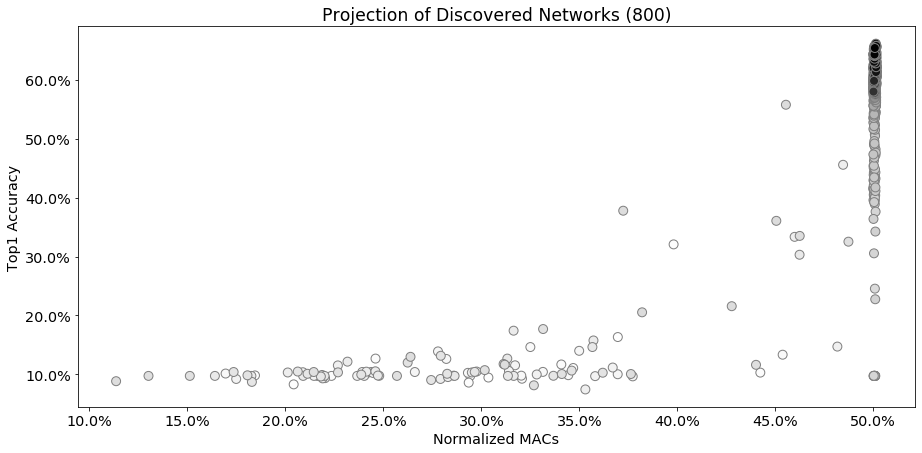

In [11]:
top1 = df['top1']
normalized_macs = df['normalized_macs']
plot_2d_embeddings(top1, normalized_macs)

### Video animation

In [ ]:
a = AnimatedScatter(normalized_macs, top1)
plt.title('Projection of Discovered Networks ({})'.format(len(top1)))  
plt.xlabel('Normalized MACs')
plt.ylabel('Top1 Accuracy')
#a.ani.save('amc_vgg16.mp4', fps=10, dpi=80) #Frame per second controls speed, dpi controls the quality 
rc('animation', html='html5')
a.ani

## Plot a histogram of the actions

We want to look at the distribution of the sampled agent actions (```agent_actions``` below), to make sure they are not skewed or biased.

We also want to compare these actions to the actions the environment actually acts on (these we call ```env_actions``` below).  
For Clipped-PPO this is extra-interesting: The natural PPO action-space is (-inf, inf) so the environment needs to scale and shift the agent actions to fit into the "real" action-space.

In [12]:
def get_all_actions(df, action_type='action_history'):
    actions = []
    for index, record in df.iterrows():
        #layer_sparsities = record[action_type]
        #layer_sparsities = layer_sparsities[1:-1].split(",")
        layer_sparsities = json.loads(record[action_type])
        layer_sparsities = [float(sparsity) for sparsity in layer_sparsities]
        actions.extend(layer_sparsities)
    return actions

14400


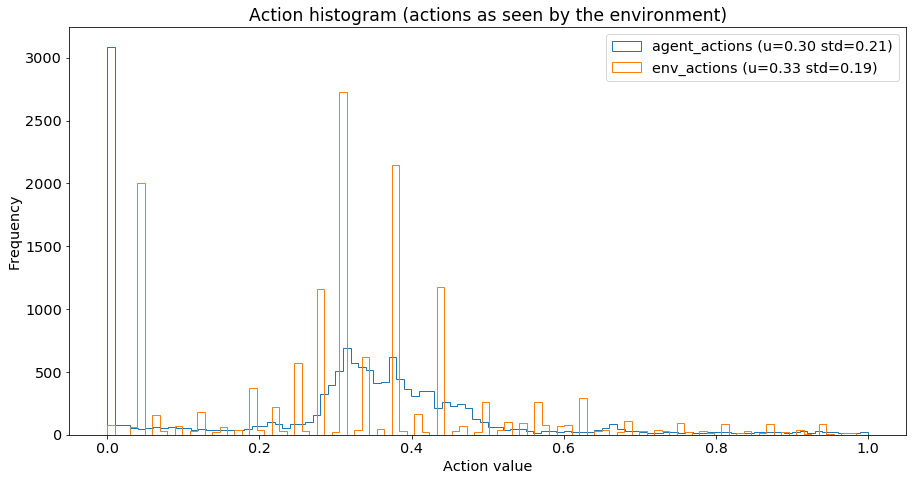

In [13]:
agent_actions = get_all_actions(df, action_type='agent_action_history')
env_actions = get_all_actions(df, action_type='action_history')
print(len(agent_actions))

plt.figure(figsize=[15,7.5])
plt.hist(agent_actions, histtype='step', bins=100, label='agent_actions (u={:.2f} std={:.2f})'.format(
                                                                                        np.mean(agent_actions),
                                                                                        np.std(agent_actions)));
plt.hist(env_actions, histtype='step', bins=100, label='env_actions (u={:.2f} std={:.2f})'.format(
                                                                                        np.mean(env_actions),
                                                                                        np.std(env_actions)));

plt.title('Action histogram (actions as seen by the environment)')
plt.legend()
plt.xlabel('Action value')
plt.ylabel('Frequency');